# Monowai CC tests

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from obspy import read_inventory
import os
import ccf

In [2]:
%matplotlib notebook

### open a file

In [3]:
def filename(path:str, r1:dict, r2:dict, time:pd.datetime):
    pair = '-'.join([ccf.helpers.merge_receiver(r1), ccf.helpers.merge_receiver(r2)])
    return os.path.join(path,pair,'{p}.{y:04d}.{d:03d}.nc'.format(p=pair,y=time.year,d=time.dayofyear))

In [5]:
time = pd.to_datetime('2015-06-16')

hydro = {
    'network'  : 'IM',
    'station'  : 'H03S1',
    'location' : '',
    'channel'  : 'EDH',
}
seism = {
    'network'  : 'IU',
    'station'  : 'RAR',
    'location' : '10',
    'channel'  : 'BHZ',
}

vel = dict( min=1.46, max=1.50 )

bhz = ccf.open_dataset( filename('tests/full', hydro, seism, time) )
bhr = None

assert bhz, 'No data found!'

if bhz:
    ccf.bias_correct_dataset(bhz,unbiased_var='cc_w')
if bhr:
    ccf.bias_correct_dataset(bhr,unbiased_var='cc_w')

### CCF noise window

<IPython.core.display.Javascript object>


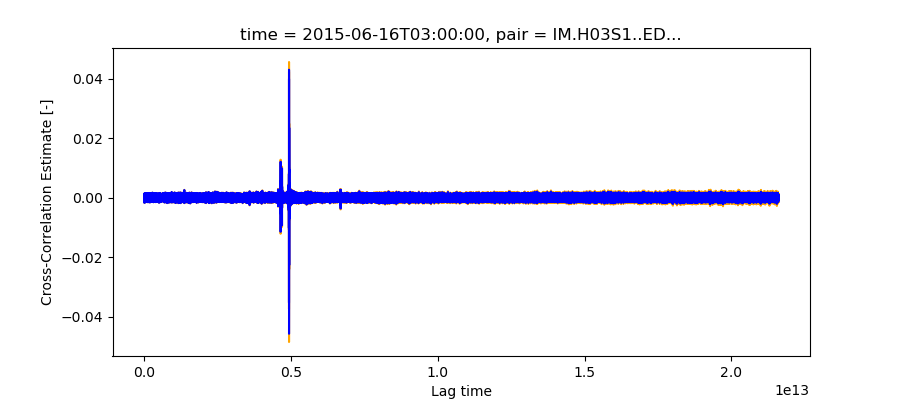

In [6]:
plt.figure(figsize=[9,4])
bhz.cc_w.loc[{'time':bhz.time[1]}].plot.line(x='lag',add_legend=False,color='orange')
bhz.cc.loc[{'time':bhz.time[1]}].plot.line(x='lag',add_legend=False,color='blue')

In [7]:
noise_lim = pd.to_timedelta([bhz.time.window_length * v for v in [.2, .25]], unit='s')

noise_win = (
    ( bhz.lag/ccf.helpers.one_second >= noise_lim[0]/ccf.helpers.one_second ) & 
    ( bhz.lag/ccf.helpers.one_second <= noise_lim[1]/ccf.helpers.one_second )
)

signal_lim = pd.to_timedelta((bhz.distance.values/vel['max'],bhz.distance.values/vel['min']), unit = 's' )

signal_win = (
    ( bhz.lag/ccf.helpers.one_second >= signal_lim[0]/ccf.helpers.one_second ) & 
    ( bhz.lag/ccf.helpers.one_second <= signal_lim[1]/ccf.helpers.one_second )
)

valid_win = ( abs(bhz.lag/ccf.helpers.one_second) <= noise_lim[1]/ccf.helpers.one_second )

i = 1

print('signal : ', signal_lim)
print('noise  : ', noise_lim)

signal :  TimedeltaIndex(['01:21:12.241480', '01:23:25.727548'], dtype='timedelta64[ns]', freq=None)
noise  :  TimedeltaIndex(['04:48:00', '06:00:00'], dtype='timedelta64[ns]', freq=None)


<IPython.core.display.Javascript object>


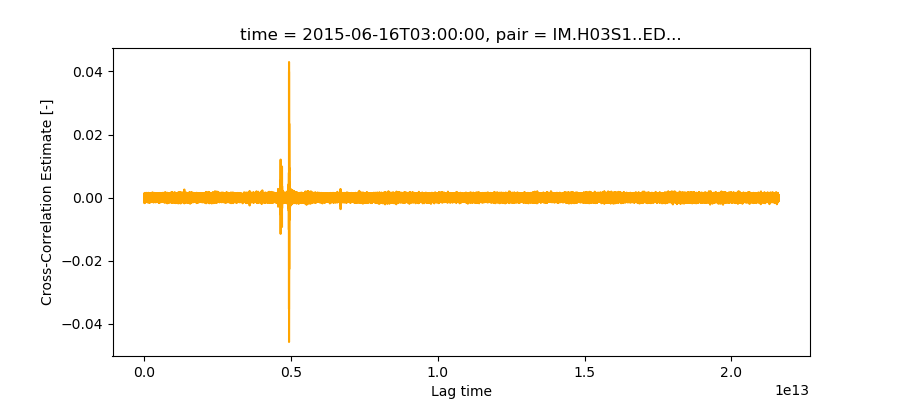

In [8]:
plt.figure(figsize=[9,4])
if bhr:
    bhr.cc.loc[{'time':bhr.time[i],'lag':bhr.lag[valid_win]}].plot.line(x='lag',add_legend=False,color='blue')
if bhz:
    bhz.cc.loc[{'time':bhz.time[i],'lag':bhz.lag[valid_win]}].plot.line(x='lag',add_legend=False,color='orange')

<IPython.core.display.Javascript object>


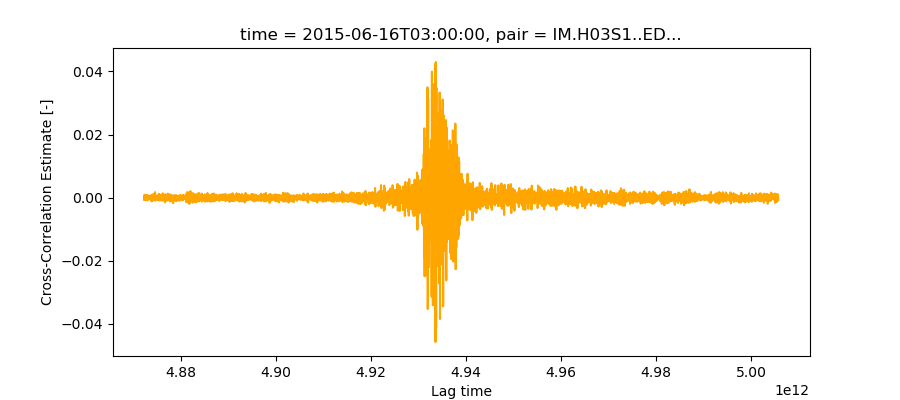

In [9]:
plt.figure(figsize=[9,4])
if bhr:
    bhr.cc.loc[{'time':bhr.time[i],'lag':bhr.lag[signal_win]}].plot.line(x='lag',add_legend=False,color='blue')
if bhz:
    bhz.cc.loc[{'time':bhz.time[i],'lag':bhz.lag[signal_win]}].plot.line(x='lag',add_legend=False,color='orange')

<IPython.core.display.Javascript object>


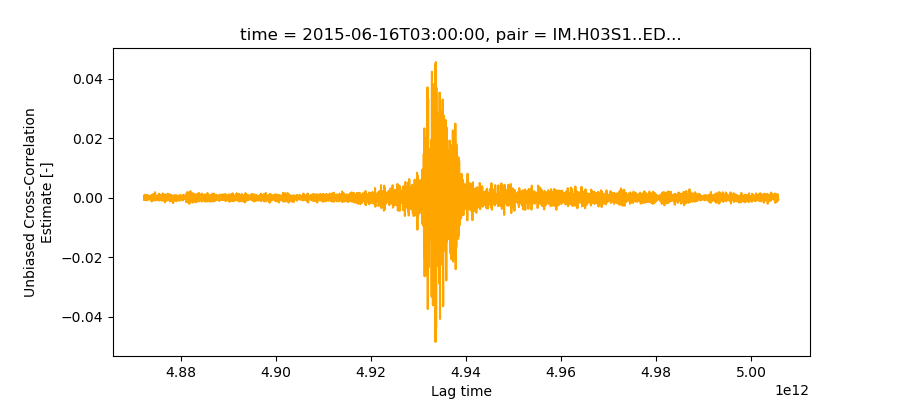

In [10]:
plt.figure(figsize=[9,4])
if bhr:
    bhr.cc_w.loc[{'time':bhr.time[i],'lag':bhr.lag[signal_win]}].plot.line(x='lag',add_legend=False,color='blue')
if bhz:
    bhz.cc_w.loc[{'time':bhz.time[i],'lag':bhz.lag[signal_win]}].plot.line(x='lag',add_legend=False,color='orange')

<IPython.core.display.Javascript object>


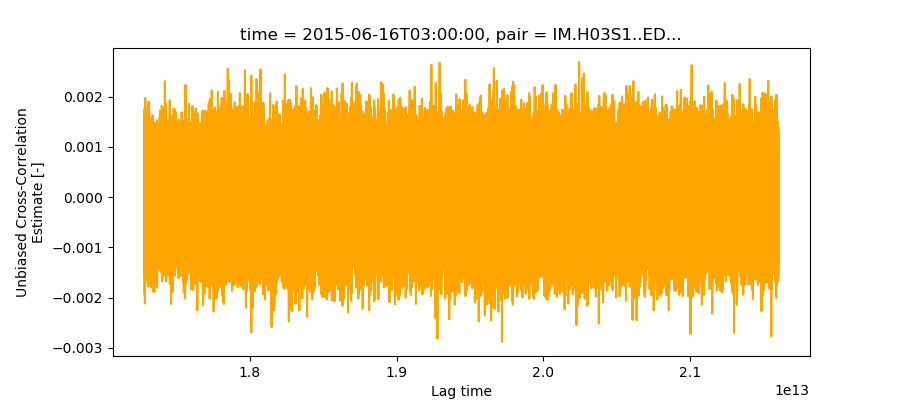

In [11]:
plt.figure(figsize=[9,4])
if bhr:
    bhr.cc_w.loc[{'time':bhr.time[i],'lag':bhr.lag[noise_win]}].plot.line(x='lag',add_legend=False,color='blue')
if bhz:
    bhz.cc_w.loc[{'time':bhz.time[i],'lag':bhz.lag[noise_win]}].plot.line(x='lag',add_legend=False,color='orange')

In [12]:
if bhz:
    bhz['snr'] = ( 
        ccf.postprocess.rms(bhz.cc_w.loc[{'lag':bhz.lag[signal_win]}]) / 
        ccf.postprocess.rms(bhz.cc_w.loc[{'lag':bhz.lag[noise_win]}])
    )
    print(bhz.snr)
    
if bhr:
    bhr['snr'] = ( 
        ccf.postprocess.rms(bhr.cc_w.loc[{'lag':bhr.lag[signal_win]}]) / 
        ccf.postprocess.rms(bhr.cc_w.loc[{'lag':bhr.lag[noise_win]}])
    )
    print(bhr.snr)

<xarray.DataArray 'snr' (time: 8)>
array([6.7197595, 6.7383685, 6.599095 , 7.688198 , 7.41678  , 6.9992685,
       6.2751284, 5.599253 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2015-06-16 ... 2015-06-16T21:00:00
    pair     object ...


### CCF full day (#8)

<IPython.core.display.Javascript object>


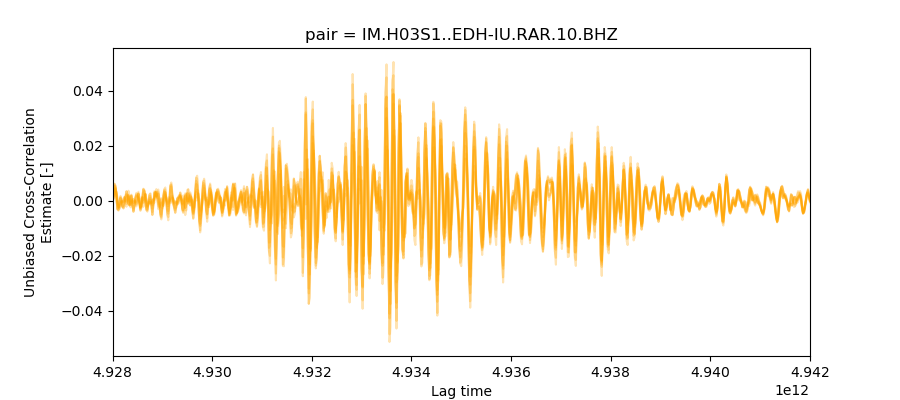

(4928000000000.0, 4942000000000.0)

In [78]:
snr_min = 4

plt.figure(figsize=[9,4])
if bhr and any(bhr.snr >= snr_min):
    bhr.cc_w.loc[{'time':bhr.time[bhr.snr >= snr_min],'lag':bhr.lag[signal_win]}].plot.line(x='lag',add_legend=False,color='blue',alpha=0.3)
if bhz and any(bhz.snr >= snr_min):
    bhz.cc_w.loc[{'time':bhz.time[bhz.snr >= snr_min],'lag':bhz.lag[signal_win]}].plot.line(x='lag',add_legend=False,color='orange',alpha=0.3)
plt.xlim([4928e9, 4942e9])

## Filter CC

In [111]:
cc_filt = ccf.postprocess.butterworth_filter(bhz.cc,order=4,btype='bandpass',frequency=[15.,16.])

<IPython.core.display.Javascript object>


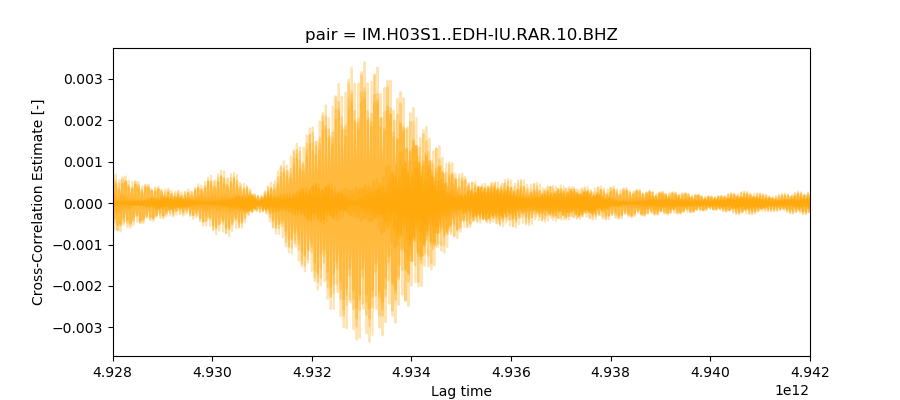

(4928000000000.0, 4942000000000.0)

In [112]:
snr_min = 4

plt.figure(figsize=[9,4])
if bhz and any(bhz.snr >= snr_min):
    cc_filt.loc[{'time':cc_filt.time[bhz.snr >= snr_min],'lag':cc_filt.lag[signal_win]}].plot.line(x='lag',add_legend=False,color='orange',alpha=0.3)
plt.xlim([4928e9, 4942e9])